In [611]:
from proxmin import nmf
from proxmin.utils import Traceback
from scipy.optimize import linear_sum_assignment
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
import time
from proxmin import operators as po
from functools import partial

In [612]:
data = np.load("hsc_stacked.npy")

In [613]:
redshifts = data['z_cl']

# Bin the cluster data by redshift
clusters1 = data[(redshifts > 0.1) & (redshifts < 0.2)]
clusters2 = data[(redshifts > 0.2) & (redshifts < 0.35)]
clusters3 = data[(redshifts > 0.35) & (redshifts < 0.5)]
clusters4 = data[(redshifts > 0.5) & (redshifts < 0.75)]
clusters5 = data[(redshifts > 0.75) & (redshifts < 1.2)]

In [614]:
num_radial_bins = 15

In [615]:
# Compute the average colors (and their variances) for a given redshift bin

def get_clusters_data(clusters):
    
    clusters = clusters[np.where(clusters['R'] > 0.1)]
    radii = np.array(clusters['R'])
    
    # Arrays containing magnitude data in four different filters
    g = np.array(clusters['gmag_forced_cmodel'])
    r = np.array(clusters['rmag_forced_cmodel'])
    i = np.array(clusters['imag_forced_cmodel'])
    z = np.array(clusters['zmag_forced_cmodel'])
    
    g_pruned = g[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    r_pruned = r[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    i_pruned = i[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    z_pruned = z[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]

    radii_pruned = radii[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    radial_bins = np.logspace(np.log10(np.amin(radii_pruned)), np.log10(0.9*np.amax(radii_pruned)), num_radial_bins + 1)
    widths = np.diff(radial_bins)
    annular_areas = np.pi * np.diff(radial_bins ** 2.)

    
    # For each color g-r, r-i, and i-z: first, throw out data points that have magnitudes of "nan" or "inf" (pruning the
    # arrays of radii and magnitudes accordingly), then use scipy.binned_statistic to sort the data into radial bins and
    # compute the number of objects and the sum and variance (noise^2) of the color values in those bins

    
    gr = g_pruned - r_pruned
    counts = binned_statistic(radii_pruned, gr, 'count', radial_bins)[0]
    sum_gr = binned_statistic(radii_pruned, gr, 'sum', radial_bins)[0]
    var_gr = binned_statistic(radii_pruned, gr, np.var, radial_bins)[0]
    var_gr *= counts

    ri = r_pruned - i_pruned
    sum_ri = binned_statistic(radii_pruned, ri, 'sum', radial_bins)[0]
    var_ri = binned_statistic(radii_pruned, ri, np.var, radial_bins)[0]
    var_ri *= counts

    iz = i_pruned - z_pruned
    sum_iz = binned_statistic(radii_pruned, iz, 'sum', radial_bins)[0]
    var_iz = binned_statistic(radii_pruned, iz, np.var, radial_bins)[0]
    var_iz *= counts
    
    return (radial_bins, widths, annular_areas, counts, (sum_gr, var_gr), (sum_ri, var_ri), (sum_iz, var_iz))

In [669]:
# Use NMF to unmix the color profiles generated by plot_profiles and avg_colors
# The arguments of "unmix" are 2-tuples of the form (mean_color, var_color). For example, gr is really (mean_gr, var_gr)

def prox_field(S, step):
    S[0, :] = 1
    #S[1:, -1] = 0
    S[1:, :] /= S[1:,:].max(axis=1)[:,None]
    return S

def prox_ndens(X, step):
    X[0, :] = np.maximum(0, X[0, :])

def unmix(counts, gr, ri, iz, annular_areas):
    n = num_radial_bins     # component resolution
    k = 2                   # number of components
    b = 4                   # number of observations (b=4 for counts, g-r, r-i, and i-z)

    # Data matrix to be unmixed
    Y = np.array([counts, gr[0], ri[0], iz[0]]) / annular_areas
    
    # if noise is variable, specify variance matrix of the same shape as Y
    W = 1. / (np.array([counts, gr[1], ri[1], iz[1]]) / annular_areas**2)

    # initialize and run NMF
    A = np.random.uniform(size = (b, k))
    S = np.random.uniform(size = (k, n))
    
    pA = po.prox_id
    pS = po.AlternatingProjections([prox_field, po.prox_plus])
    
    nmf(Y, A, S, W=W, prox_A=pA, prox_S=pS, e_rel=1e-6, e_abs=0)
    
    return A, S

In [681]:
def plot_profiles(clusters_data, z_bin_num, area_normalization=True):
    

    radial_bins = clusters_data[0]
    bin_midpoints = (radial_bins[1:] * radial_bins[:-1]) ** 0.5
    widths = clusters_data[1]
    annular_areas = clusters_data[2]
    counts = clusters_data[3]
    
    # gr, ri, iz, are 2-tuples of the form (sum_color, var_color)
    gr = clusters_data[4]
    ri = clusters_data[5]
    iz = clusters_data[6]
    
    A, S = unmix(counts, gr, ri, iz, annular_areas)
    print("A:\n", A, "\n")
    print("A / (total number density):\n", A / A[0].sum(), "\n")
    print("S:\n", S, "\n")
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")
    
    # Plot S_k (the relative abundance of the kth component) vs. radius for each k
    
    for k in range(S.shape[0]):
        plt.plot(bin_midpoints, S[k], label = "Component %s" % (k+1))
    plt.xscale('log')
    plt.title("Relative Component Abundance vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel("Relative abundance")
    plt.legend()
    plt.show()
    

    Y_remixed = np.dot(A, S)
    
    # Plot the reconstructed color profiles following NMF 
    # (that is, plot Y_remixed = A x S, where A and S are the results of factorizing the initial data matrix Y)
    
    if(area_normalization):
        
        plt.bar(radial_bins[:-1], counts/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(counts/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[0], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[0,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("Galaxy Number Density vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"Number Density $[\frac{counts}{Mpc^2}]$")
        plt.legend()
        plt.show()
        
        plt.bar(radial_bins[:-1], gr[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(gr[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[1], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[1,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("g-r Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{g-r}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], ri[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(ri[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[2], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[2,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("r-i Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{r-i}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], iz[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(iz[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[3], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[3,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("i-z Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{i-z}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        
    else:
        plt.bar(radial_bins[:-1], gr[0], width=widths, align="edge", yerr=np.sqrt(gr[1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[1], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average g-r [magnitudes]")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], ri[0], width=widths, align="edge", yerr=np.sqrt(ri[1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[2], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average r-i [magnitudes]")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], iz[0], width=widths, align="edge", yerr=np.sqrt(iz[1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[3], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average i-z [magnitudes]")
        plt.legend()
        plt.show()

In [692]:
#Extract data from clusters1

clusters1_data = get_clusters_data(clusters1)

A:
 [[ 7052.76221459  2120.28719939]
 [ 4970.17982183  1840.86511141]
 [ 3716.96131881   846.68314678]
 [ 2347.4520327    562.26286496]] 

A / (total number density):
 [[ 0.76885689  0.23114311]
 [ 0.54182416  0.20068191]
 [ 0.40520455  0.09230116]
 [ 0.25590749  0.06129509]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 0.69493479  0.71151872  1.          0.30996997  0.37846603  0.16200924
   0.4142765   0.04786941  0.06119839  0.21334984  0.1305924   0.32181033
   0.39532822  0.57159387  0.72071256]] 



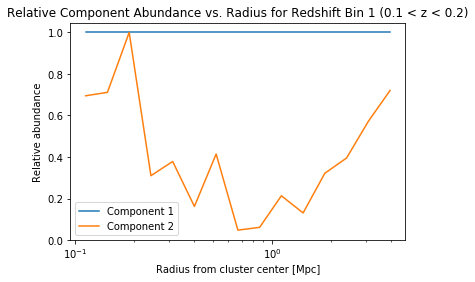

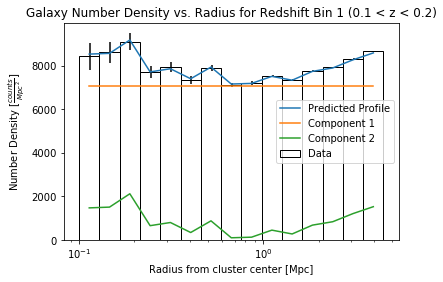

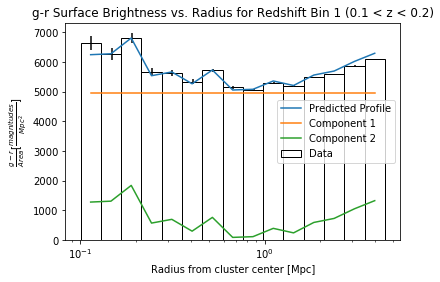

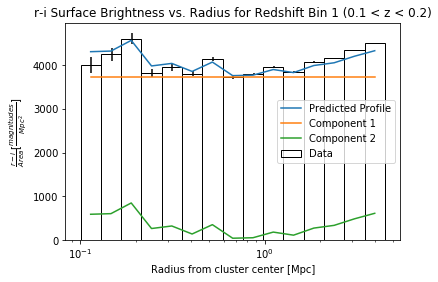

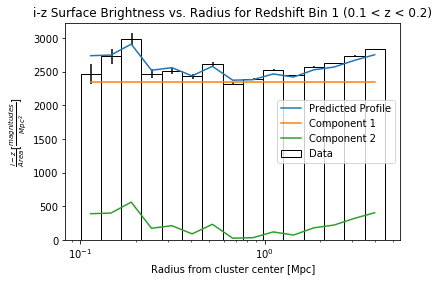

In [683]:
#Plot bar graphs for the post-NMF clusters1 profiles

plot_profiles(clusters1_data, 1, area_normalization=True)

In [684]:
#Plot bar graphs for the clusters2 data

clusters2_data = get_clusters_data(clusters2)

A:
 [[ 14714.02674105   8711.02415842]
 [ 10050.41369525  10329.62776918]
 [  7731.39641142   3896.0214605 ]
 [  4834.04103864   2426.29550144]] 

A / (total number density):
 [[ 0.62813211  0.37186789]
 [ 0.42904554  0.44096501]
 [ 0.33004822  0.16631859]
 [ 0.20636203  0.10357696]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.73195718  0.61597895  0.55909628  0.57044516  0.43197325
   0.29594109  0.2626666   0.14408078  0.11678504  0.08589478  0.09418391
   0.09743766  0.09585377  0.0401412 ]] 



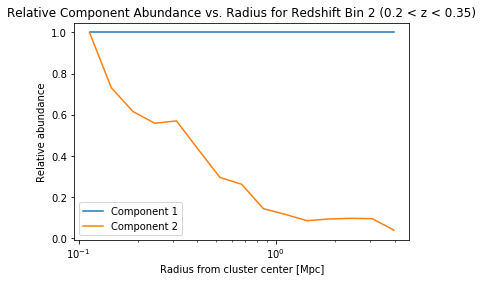

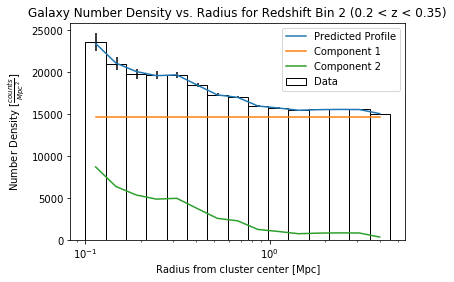

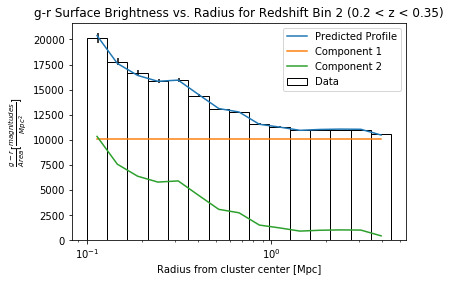

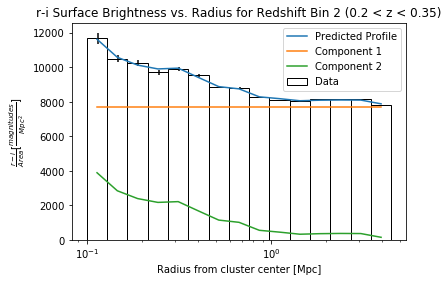

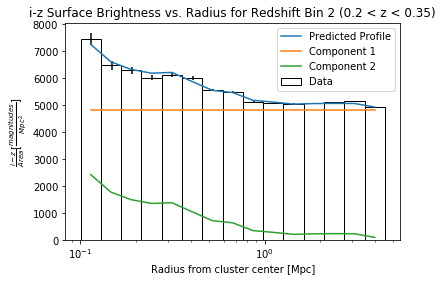

In [685]:
#Plot bar graphs for the post-NMF clusters2 profiles

plot_profiles(clusters2_data, 2, area_normalization=True)

In [686]:
#Plot bar graphs for the clusters3 data

clusters3_data = get_clusters_data(clusters3)

A:
 [[ 5494.401859    4784.78569631]
 [ 3890.50722328  6128.1398329 ]
 [ 2843.27176956  2676.67170893]
 [ 1816.97489796  1492.33051049]] 

A / (total number density):
 [[ 0.53451713  0.46548287]
 [ 0.37848392  0.59616967]
 [ 0.27660472  0.2603972 ]
 [ 0.1767625   0.14517981]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 0.87337591  1.          0.74991497  0.6363374   0.54824459  0.47099188
   0.35125283  0.22984665  0.16696563  0.12096176  0.05996793  0.01139685
   0.01498826  0.02057522  0.01179712]] 



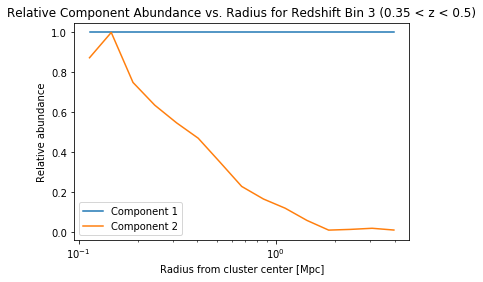

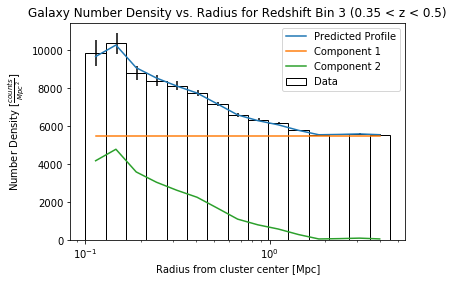

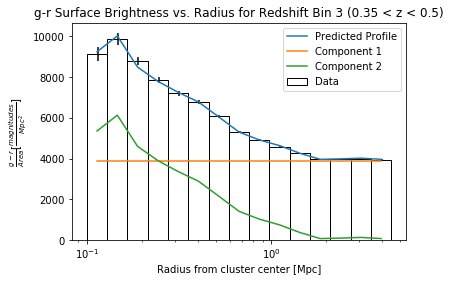

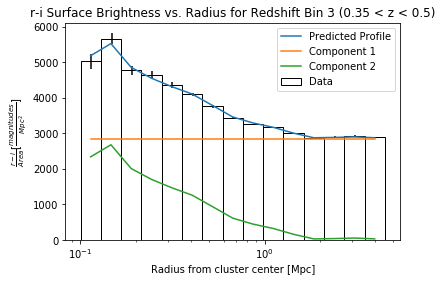

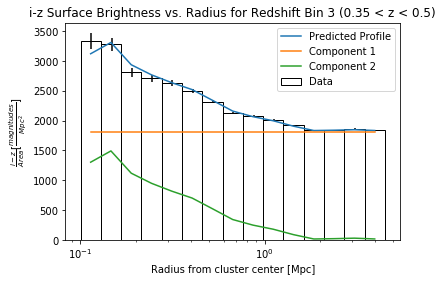

In [687]:
#Plot bar graphs for the post-NMF clusters3 profiles

plot_profiles(clusters3_data, 3, area_normalization=True)

In [688]:
#Plot bar graphs for the clusters4 data

clusters4_data = get_clusters_data(clusters4)

A:
 [[ 2882.04593505  4029.30701648]
 [ 2059.19132568  5736.35540564]
 [ 1497.25235685  3856.31115962]
 [  906.20140269  1632.34312416]] 

A / (total number density):
 [[ 0.4170017   0.5829983 ]
 [ 0.2979433   0.82999023]
 [ 0.21663665  0.55796762]
 [ 0.1311178   0.23618286]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.67181142  0.52371168  0.3766443   0.30392706  0.24442153
   0.1735893   0.10797275  0.06464855  0.0374822   0.01841784  0.02691643
   0.0127381   0.01077077  0.01368672]] 



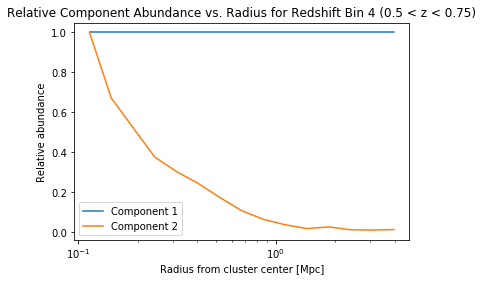

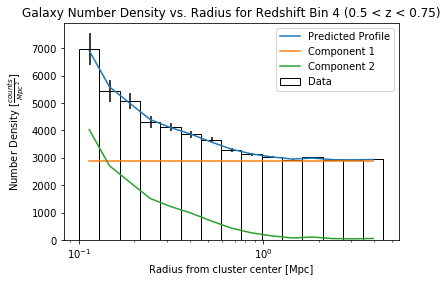

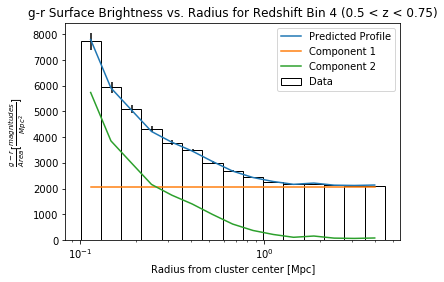

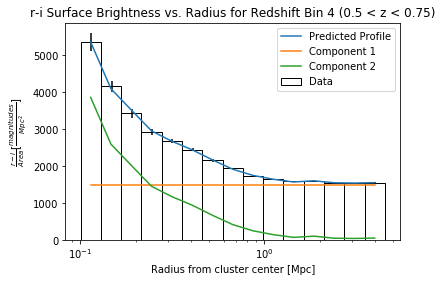

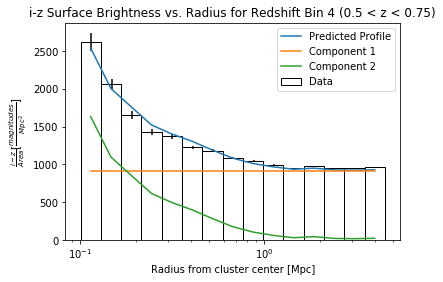

In [689]:
#Plot bar graphs for the post-NMF clusters4 profiles

plot_profiles(clusters4_data, 4, area_normalization=True)

In [690]:
#Plot bar graphs for the clusters5 data

clusters5_data = get_clusters_data(clusters5)

A:
 [[ 2119.47018817  3550.32630959]
 [ 1351.6939094   5012.06943525]
 [ 1088.03822416  3736.13449323]
 [  678.4766217   2040.46220101]] 

A / (total number density):
 [[ 0.37381768  0.62618232]
 [ 0.23840254  0.88399459]
 [ 0.19190075  0.6589539 ]
 [ 0.11966507  0.35988279]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.62145983  0.48642008  0.43795539  0.38038813  0.27753959
   0.22294308  0.2029275   0.15222969  0.11592132  0.08060336  0.03431811
   0.01796972  0.01768821  0.01287893]] 



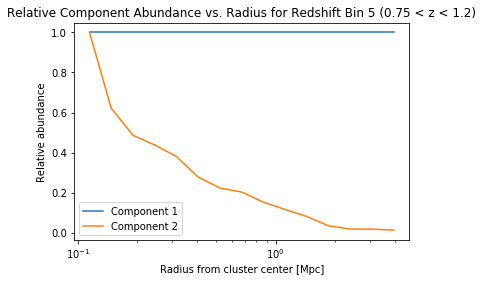

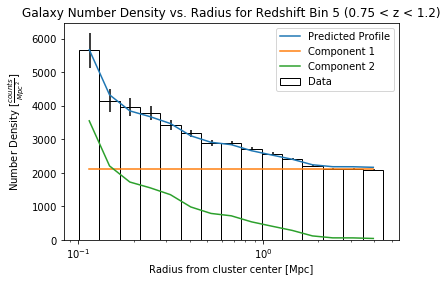

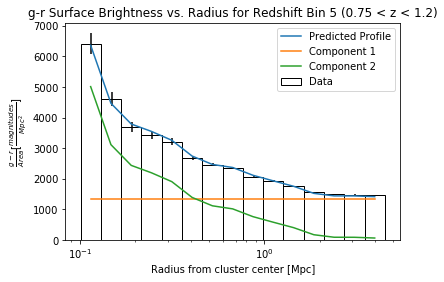

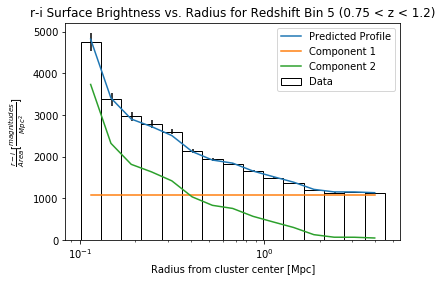

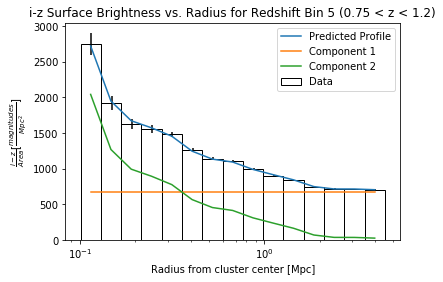

In [691]:
#Plot bar graphs for the post-NMF clusters5 profiles

plot_profiles(clusters5_data, 5, area_normalization=True)